# Image Classification



##  Multi-Class Classification

Captchas were invented to prevent bots from attacking websites. But the ML models are breaking captchas. Thus, stronger captchas are being invented. In this part, we will train a ML model to break hcaptcha (https://www.hcaptcha.com/ )!!



### Importing required libraries

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
%%capture
!pip install split-folders

In [6]:
# Importing libraries

import numpy as np
from keras.preprocessing import image
import cv2

import matplotlib.pyplot as plt
from pathlib import Path
import os
from skimage import feature
from sklearn.metrics import accuracy_score

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [8]:
import os                      
classes = os.listdir("data/")
print(classes)

['train', 'truck', 'airplane', 'motorcycle', 'seaplane', 'boat', 'motorbus', 'bicycle']


In [9]:
import zipfile
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall('data2')
  zip_ref.close()

In [10]:
unzip_data('hcaptcha_dataset.zip')

In [6]:
#unzip_data('/content/drive/MyDrive/Colab Notebooks/data/Multiclass/hcaptcha_dataset_new.zip')

### 1. Data Cleaning and Visualization

Check out the labels in the dataset. How many images belong to each class?

In [11]:
def process(container_path): # to load images files
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]
    count = 0
    train_img = []
    counts = []
    uni_shapes = []

    for i, direc in enumerate(folders):
        s = 0
        sub_train = []
        for file in direc.iterdir():
            count += 1
            s += 1
            img = cv2.imread(str(file))
            sub_train.append(img)
            if img.shape not in uni_shapes:
              uni_shapes.append(img.shape)
#         sub_train = np.array(sub_train)
        train_img.append(sub_train)
        counts.append(s)

#     X = np.array(train_img)
    return train_img,counts,categories, uni_shapes

In [14]:
# Train dataset
path0 = "data2/hcaptcha_dataset"
#X_train = []
X_train,train_counts,train_categories,train_shapes = process(path0+"/train")
#X_train,train_counts,train_categories,train_shapes = process(path0)

print("Trainig Files imported successfully")

print(len(X_train),"class of datasets\n")
print("Dataset--Count\n")
sm = 0
for i in range(len(X_train)):
    print(train_categories[i],"--\t",train_counts[i])
    sm += train_counts[i]
print('Total images = ', sm)

Trainig Files imported successfully
7 class of datasets

Dataset--Count

truck --	 656
airplane --	 402
motorcycle --	 592
seaplane --	 280
boat --	 528
motorbus --	 256
bicycle --	 304
Total images =  3018


In [15]:
# Test dataset

X_test = []
X_test,test_counts,test_categories,test_shapes = process(path0+"/test")
print("Testing Files imported successfully")

print(len(X_train),"Class of dataset\n")
print("Dataset--Count\n")
sm = 0
for i in range(len(X_train)):
    print(test_categories[i],"--\t",test_counts[i])
    sm += test_counts[i]
print('Total images = ', sm)

Testing Files imported successfully
7 Class of dataset

Dataset--Count

truck --	 163
airplane --	 101
motorcycle --	 141
seaplane --	 75
boat --	 134
motorbus --	 61
bicycle --	 71
Total images =  746


In [16]:
X_train[5][0].shape

(128, 128, 3)

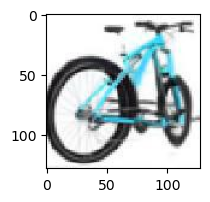

In [17]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[6][0])

Write a function to display a random image and its shape. Find out whether
the shape of each image is the same or not. If not then make all images of the
same shape.

In [18]:
def random_image_show(dataset, categories):
  lg_class = len(dataset)
  rn_class = np.random.random_integers(0, lg_class-1)
  lg = len(dataset[rn_class])
  rn = np.random.random_integers(0, lg -1)
  plt.figure(figsize=(2,2))
  plt.imshow(dataset[rn_class][rn])
  print("Shape - ", dataset[rn_class][rn].shape, rn)
  return dataset[rn_class][rn], categories[rn_class], rn_class

Shape -  (128, 128, 3) 21
airplane


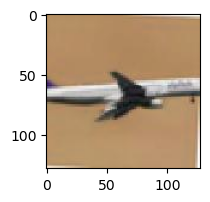

In [19]:
ixs, cat, cat_no = random_image_show(X_train, train_categories)
print(cat)

In [20]:
def image_shape(dataset):
  un_shapes = {}
  for i in range (len(dataset)):
    for j in range (len(dataset[i])):
      if dataset[i][j].shape not in un_shapes:
        un_shapes[dataset[i][j].shape] = 1
        print(i,j)
      else:
        un_shapes[dataset[i][j].shape] += 1

  return un_shapes

In [21]:
image_shape(X_train)

0 0
0 65


{(128, 128, 3): 2939, (144, 144, 3): 79}

In [22]:
image_shape(X_test)

0 0
0 7


{(128, 128, 3): 726, (144, 144, 3): 20}

In [23]:
x = X_train.copy()
t = train_counts.copy()

In [24]:
sum(t)

3018

In [25]:
len(X_train)

7

In [26]:
import matplotlib.image as mpimg
import tensorflow as tf

IMAGE_SIZE = 128
tf.compat.v1.disable_eager_execution() # for faster working with tensorflow
tf.compat.v1.disable_v2_behavior() # compat allows you to write code that works both in TensorFlow 1. x and 2. x.

def tf_resize_images(X_images):
    X_data = []
    tf.compat.v1.reset_default_graph()
    X = tf.compat.v1.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize(X, (IMAGE_SIZE, IMAGE_SIZE), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        for index, img in enumerate(X_images):
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    print(len(X_data))
    return X_data

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
%%time
X_train =[ tf_resize_images(x) for x in X_train]

In [68]:
sum(train_counts),  train_counts

(3018, [656, 402, 592, 280, 528, 256, 304])

In [69]:
image_shape(X_train)

0 0


{(128, 128, 3): 3018}

In [70]:
X_train[0][0].shape, X_train[0][34].shape

((128, 128, 3), (128, 128, 3))

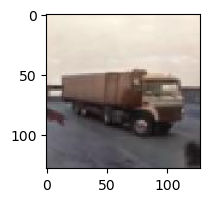

In [71]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[0][0]/255)

In [27]:
%%time
X_test = [ tf_resize_images(x) for x in X_test]

2023-08-17 20:11:04.130041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 20:11:04.130245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 20:11:04.398690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

163
101
141
75


2023-08-17 20:11:08.770999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 20:11:08.771320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 20:11:08.771555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

134
61
71
CPU times: user 1 s, sys: 3.18 s, total: 4.18 s
Wall time: 9.02 s


2023-08-17 20:11:08.994272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 20:11:08.994497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-17 20:11:08.994663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [28]:
image_shape(X_test)

0 0


{(128, 128, 3): 746}

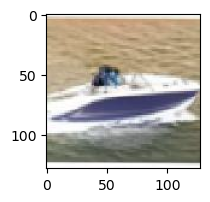

In [29]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[4][12]/255)

d) Do you think removing color channels (R, G, B) from images would lead to
poor modeling? How can you justify converting each image to greyscale? What
will be the effect of using a colored 3-channel image over a grayscale one on the
classification model’s performance?

It depends on your object of classification. If color has no significance in your images to classify then its better to go for grey scale images to avoid false classification and complexities.

truck - Shape -  (128, 128, 3)
airplane - Shape -  (128, 128, 3)
motorcycle - Shape -  (128, 128, 3)
seaplane - Shape -  (144, 144, 3)
boat - Shape -  (128, 128, 3)
motorbus - Shape -  (128, 128, 3)
bicycle - Shape -  (128, 128, 3)


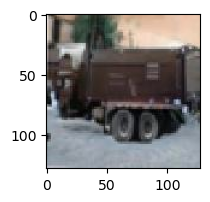

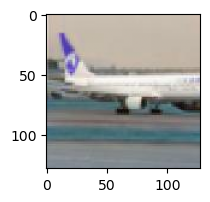

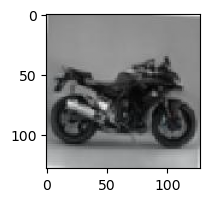

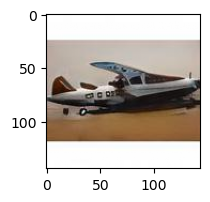

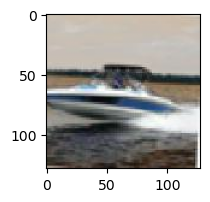

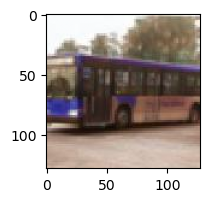

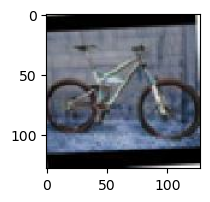

In [30]:
for c in range (7):
  lg_class = len(X_train)
  lg = len(X_train[c])
  rn = np.random.random_integers(0, lg -1)
  plt.figure(figsize=(2,2))
  plt.imshow(X_train[c][rn]/255)
  print(train_categories[c] ,"- Shape - ", X_train[c][rn].shape)

In [31]:
# color_train = X_train.copy()
# color_test = X_test.copy()

In [76]:
len(X_train[0][5][0][0])
X_train[0][5][0].ndim

2

In [65]:
t = np.array(X_train).resape(4596, 128, 128, 3)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

In [32]:
Images_train = np.array([img for cls in X_train for img in cls])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3018,) + inhomogeneous part.

In [78]:
Images_train.shape

(3018, 128, 128, 3)

In [69]:
def convert_to_grey(dataset):
  grey = []
  for img in dataset:
#       r, g, b = Images_train[:,:,0], Images_train[:,:,1], Images_train[:,:,2]
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      grey.append(np.array(gray))
  return np.array(grey)

In [72]:
grey_train = convert_to_grey(Images_train)

NameError: name 'Images_train' is not defined

In [81]:
grey_train.shape

(3018, 128, 128)

In [82]:
def Normalize(dataset):
    for idx in range(len(dataset)):
        dataset[idx] /= 255
    return dataset

In [83]:
Images_train = Normalize(Images_train)
grey_train = Normalize(grey_train)

In [84]:
Images_test = np.array([img for cls in X_test for img in cls])
Images_test.shape

(746, 128, 128, 3)

In [85]:
grey_test = convert_to_grey(Images_test)
grey_test.shape

(746, 128, 128)

In [86]:
Images_test = Normalize(Images_test)
grey_test = Normalize(grey_test)

In [87]:
train_counts, train_categories

([656, 402, 592, 280, 528, 256, 304],
 ['truck',
  'airplane',
  'motorcycle',
  'seaplane',
  'boat',
  'motorbus',
  'bicycle'])

In [88]:
# train_lable =

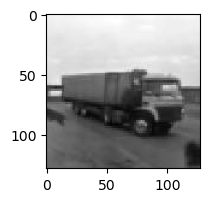

In [89]:
plt.figure(figsize=(2,2))
plt.imshow(grey_train[0], 'gray')

 Obviously it will be much accurate of using a colored 3-channel image over a grayscale one on the classification model’s performance

e) Should you normalize your color channel values? Based on your answers do
the steps you think will be best for your model.

Normalizing image inputs: Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

In [90]:
Images_train.shape, grey_train.shape

((3018, 128, 128, 3), (3018, 128, 128))

In [91]:
# Normalising coloured image

f) Visualize 3 random training images along with the labels for each class. The
dataset was manually labeled, do you spot any errors in the labels?

No, i didn't spot any errors

In [92]:
label_train = []
for idx,lb_count in enumerate(train_counts):
  label_train.extend(lb_count*[idx])

In [93]:
import random
temp = list(zip(Images_train, label_train))
random.shuffle(temp)
train, label_train = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
train, label_train = np.array(train), np.array(label_train)
train.shape, label_train.shape

((3018, 128, 128, 3), (3018,))

(<matplotlib.image.AxesImage at 0x7fefdc11e550>, 'boat')

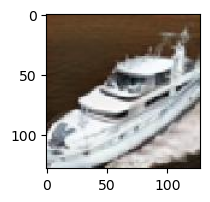

In [94]:
plt.figure(figsize=(2,2))
plt.imshow(train[300], 'gray'), train_categories[label_train[300]]

In [95]:
label_test = []
for idx,lb_count in enumerate(test_counts):
  label_test.extend(lb_count*[idx])

In [96]:
import random
temp = list(zip(Images_test, label_test))
random.shuffle(temp)
test, label_test = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
test, label_test = np.array(test), np.array(label_test)

(<matplotlib.image.AxesImage at 0x7fefdd6bd6a0>, 'motorcycle')

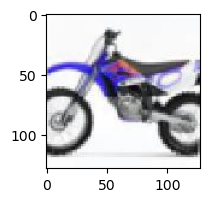

In [97]:
plt.figure(figsize=(2,2))
plt.imshow(test[40]), train_categories[label_test[40]]

In [98]:
train.shape, test.shape

((3018, 128, 128, 3), (746, 128, 128, 3))

In [99]:
np.savez('Preprocessed_train_images', train, label_train)
np.savez('Preprocessed_test_images', test, label_test)

### 2. Image Augmentation

In [100]:
%%time
npzfile = np.load('Preprocessed_train_images.npz')
train, label_train = npzfile['arr_0'], npzfile['arr_1']

In [101]:
%%time
npzfile = np.load('Preprocessed_test_images.npz')
test, label_test = npzfile['arr_0'], npzfile['arr_1']

In [102]:
train.shape, label_train.shape

((3018, 128, 128, 3), (3018,))

In [103]:
test.shape, label_test.shape

((746, 128, 128, 3), (746,))

In [166]:
import random as rn
x = rn.randint(0,80)
y = x
def zoom(image):

  new_img = image[x:x+100,y:y+100,:]
  # plt.figure(figsize=(2,2))
  # plt.imshow(new_img)
  return np.array(new_img, dtype=np.float32)

In [151]:
train.shape

(3018, 128, 128, 3)

In [167]:
i = 0
for img in train:
    t = zoom(img)
    i+=1
    print(i,t.shape)

1 (100, 100, 3)
2 (100, 100, 3)
3 (100, 100, 3)
4 (100, 100, 3)
5 (100, 100, 3)
6 (100, 100, 3)
7 (100, 100, 3)
8 (100, 100, 3)
9 (100, 100, 3)
10 (100, 100, 3)
11 (100, 100, 3)
12 (100, 100, 3)
13 (100, 100, 3)
14 (100, 100, 3)
15 (100, 100, 3)
16 (100, 100, 3)
17 (100, 100, 3)
18 (100, 100, 3)
19 (100, 100, 3)
20 (100, 100, 3)
21 (100, 100, 3)
22 (100, 100, 3)
23 (100, 100, 3)
24 (100, 100, 3)
25 (100, 100, 3)
26 (100, 100, 3)
27 (100, 100, 3)
28 (100, 100, 3)
29 (100, 100, 3)
30 (100, 100, 3)
31 (100, 100, 3)
32 (100, 100, 3)
33 (100, 100, 3)
34 (100, 100, 3)
35 (100, 100, 3)
36 (100, 100, 3)
37 (100, 100, 3)
38 (100, 100, 3)
39 (100, 100, 3)
40 (100, 100, 3)
41 (100, 100, 3)
42 (100, 100, 3)
43 (100, 100, 3)
44 (100, 100, 3)
45 (100, 100, 3)
46 (100, 100, 3)
47 (100, 100, 3)
48 (100, 100, 3)
49 (100, 100, 3)
50 (100, 100, 3)
51 (100, 100, 3)
52 (100, 100, 3)
53 (100, 100, 3)
54 (100, 100, 3)
55 (100, 100, 3)
56 (100, 100, 3)
57 (100, 100, 3)
58 (100, 100, 3)
59 (100, 100, 3)
60 (10

In [152]:
type(train[0][x:x+100,y:y+100,:])

numpy.ndarray

In [168]:
Xtrain = np.array([zoom(img) for img in train],dtype=np.float32)
Xtest = np.array([zoom(img) for img in test])

In [169]:
Xtrain.shape, Xtest.shape

((3018, 100, 100, 3), (746, 100, 100, 3))

In [116]:
plt.figure(figsize=(2,2))
plt.imshow(Xtrain[1312])

NameError: name 'Xtrain' is not defined

<Figure size 200x200 with 0 Axes>

In [ ]:
Xtrain = tf_resize_images(Xtrain)
Xtest = tf_resize_images(Xtest)

3892
1071


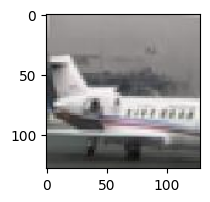

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(Xtrain[1312])

In [ ]:
train = np.vstack((train, Xtrain))
test = np.vstack((test, Xtest))

(<matplotlib.image.AxesImage at 0x7f20180fd540>, 'bicycle')

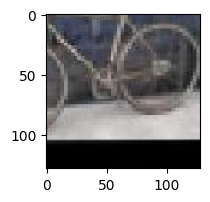

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(Xtrain[233]), train_categories[label_train[233]]

In [ ]:
file = open('Categories.txt','w')
file.write(str(train_categories))
file.close()

In [ ]:
label_train = list(label_train)*2
label_test = list(label_test)*2

In [ ]:
def suffle(x,y):
  temp = list(zip(x,y))
  rn.shuffle(temp)
  x,y = zip(*temp)
  return np.array(x), np.array(y)

In [ ]:
train, label_train = suffle(train, label_train)
test, label_test = suffle(test, label_test)

(<matplotlib.image.AxesImage at 0x7f20181a80d0>, 'traffic_light')

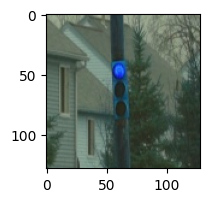

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(train[3101]), train_categories[label_train[3101]]

(<matplotlib.image.AxesImage at 0x7f1f98c68c70>, 'truck')

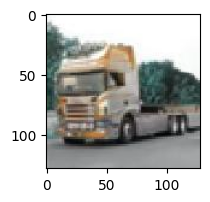

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(test[203]), train_categories[label_test[203]]

In [ ]:
np.savez('Preprocessed_train_images', train, label_train)
np.savez('Preprocessed_test_images', test, label_test)

### Load Preprocessed Data

In [4]:
npzfile = np.load('Preprocessed_train_images.npz')
train, label_train = npzfile['arr_0'], npzfile['arr_1']

In [5]:
npzfile = np.load('Preprocessed_test_images.npz')
test, label_test = npzfile['arr_0'], npzfile['arr_1']

In [6]:
train.shape, test.shape

((7784, 128, 128, 3), (2142, 128, 128, 3))

In [7]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
import seaborn as sns
import PIL
from tensorflow import keras
# import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import cv2
import random
from sklearn.metrics import roc_curve, auc
from itertools import cycle

### Fnc

In [8]:
def accuracy(model_seq, test, label_test):
  pred = np.round(model_seq.predict(test),2)
  out = []
  for i in pred:
    maxi = np.max(i)
    x = list(np.where(i==maxi))[0][0]
    out.append(x)

  res = out == label_test
  return round(sum(res)/len(res), 3), out, pred

In [9]:
def auc_roc(model,images_test, y_test):
    acc, pred, one_hot = accuracy(model, images_test, label_test)
    train_categories = ['motorbus', 'bicycle', 'airplane', 'truck', 'boat', 'motorcycle', 'seaplane', 'fire_hydrant', 'traffic_light']
    labels = np.arange(9)

    clf_report = classification_report(y_test,
                                       pred,
                                       labels=labels,
                                       target_names=train_categories,
                                       output_dict=True)

    # .iloc[:-1, :] to exclude support
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

    y_score = model.predict(images_test)

    again_test_label = []
    for i in range(len(images_test)):
        arr = np.zeros(9)
        arr[int(y_test[i])] = 1
        again_test_label.append(list(arr))

    again_test_label = np.array(again_test_label)

    # plotting a line plot after changing its width and height
    f = plt.figure()

    f.set_figwidth(10)
    f.set_figheight(10)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2

    for i in range(9):
        fpr[i], tpr[i], _ = roc_curve(again_test_label[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['b', 'r', 'g', 'c', 'm', 'y', 'k', 'purple', 'orange'])
    plt.figure(figsize=(5, 5))
    for i, color in zip(range(9), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(train_categories[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
train_categories = ['motorbus', 'bicycle', 'airplane', 'truck', 'boat', 'motorcycle', 'seaplane', 'fire_hydrant', 'traffic_light']

(<matplotlib.image.AxesImage at 0x7f680c4b23b0>, 'bicycle')

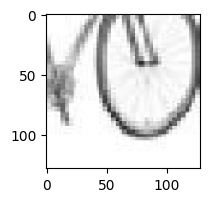

In [11]:
idx = 7000
plt.figure(figsize=(2,2))
plt.imshow(train[idx]), train_categories[label_train[idx]]

In [12]:
min(label_train), max(label_train)

(0, 8)

In [13]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history

### Model  1 (ResNet 50)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD

def build_resnet50(x_train_scaled, y_train, lr=0.01, ep=10):
    learning_rate = lr
    epp = ep
    batch_s = 28

    base_model = ResNet50(include_top=False, weights=None, input_shape=x_train_scaled.shape[1:])
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    output_layer = tf.keras.layers.Dense(9, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

    # Compile the Model
    model.compile(optimizer=SGD(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Model Training
    history = model.fit(x_train_scaled,
                        y_train,
                        epochs=epp,
                        validation_split=0.2,
                        batch_size=batch_s,
                        verbose=1)

    return model, history


In [ ]:
model_resnet,history_seq = build_model_using_sequential(train, label_train, 0.1)

Epoch 1/10
223/223 [==============================] - 5s 17ms/step - loss: 2.0838 - accuracy: 0.2076 - val_loss: 1.9744 - val_accuracy: 0.2608
Epoch 2/10
223/223 [==============================] - 3s 12ms/step - loss: 1.6989 - accuracy: 0.3891 - val_loss: 1.5122 - val_accuracy: 0.4766
Epoch 3/10
223/223 [==============================] - 3s 13ms/step - loss: 1.4128 - accuracy: 0.5020 - val_loss: 1.3033 - val_accuracy: 0.5626
Epoch 4/10
223/223 [==============================] - 3s 12ms/step - loss: 1.1426 - accuracy: 0.6014 - val_loss: 1.0791 - val_accuracy: 0.6159
Epoch 5/10
223/223 [==============================] - 3s 14ms/step - loss: 1.0079 - accuracy: 0.6554 - val_loss: 1.4029 - val_accuracy: 0.5523
Epoch 6/10
223/223 [==============================] - 3s 13ms/step - loss: 0.8939 - accuracy: 0.6880 - val_loss: 0.8805 - val_accuracy: 0.7270
Epoch 7/10
223/223 [==============================] - 3s 13ms/step - loss: 0.7823 - accuracy: 0.7353 - val_loss: 1.0207 - val_accuracy: 0.6667

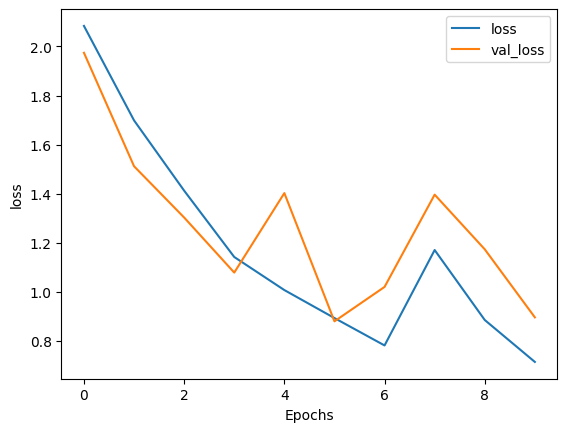

In [ ]:
plot_history(history_seq, 'loss')

In [ ]:
model_resnet,history_seq = build_model_using_sequential(train, label_train, 0.1, 50)

Epoch 1/50
223/223 [==============================] - 5s 16ms/step - loss: 2.0316 - accuracy: 0.2428 - val_loss: 1.8904 - val_accuracy: 0.2871
Epoch 2/50
223/223 [==============================] - 3s 12ms/step - loss: 1.7022 - accuracy: 0.3967 - val_loss: 1.4160 - val_accuracy: 0.5234
Epoch 3/50
223/223 [==============================] - 3s 12ms/step - loss: 1.3704 - accuracy: 0.5169 - val_loss: 1.1789 - val_accuracy: 0.6076
Epoch 4/50
223/223 [==============================] - 3s 14ms/step - loss: 1.1763 - accuracy: 0.5812 - val_loss: 1.0339 - val_accuracy: 0.6705
Epoch 5/50
223/223 [==============================] - 3s 14ms/step - loss: 1.0306 - accuracy: 0.6314 - val_loss: 1.0050 - val_accuracy: 0.6699
Epoch 6/50
223/223 [==============================] - 3s 12ms/step - loss: 0.9292 - accuracy: 0.6665 - val_loss: 1.0470 - val_accuracy: 0.6724
Epoch 7/50
223/223 [==============================] - 3s 13ms/step - loss: 0.8443 - accuracy: 0.7060 - val_loss: 0.9523 - val_accuracy: 0.6782

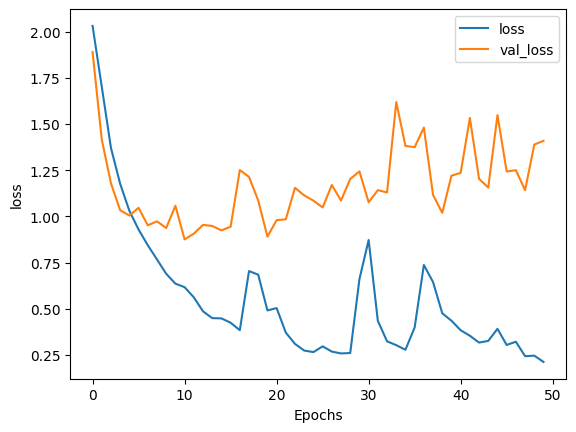

In [ ]:
plot_history(history_seq, 'loss')

In [ ]:
model_resnet,history_seq = build_model_using_sequential(train, label_train, 0.05, 50)

Epoch 1/50
223/223 [==============================] - 16s 24ms/step - loss: 2.0920 - accuracy: 0.2200 - val_loss: 1.8395 - val_accuracy: 0.3064
Epoch 2/50
223/223 [==============================] - 3s 12ms/step - loss: 1.7307 - accuracy: 0.3721 - val_loss: 1.3829 - val_accuracy: 0.5434
Epoch 3/50
223/223 [==============================] - 3s 12ms/step - loss: 1.3354 - accuracy: 0.5267 - val_loss: 1.8247 - val_accuracy: 0.3751
Epoch 4/50
223/223 [==============================] - 3s 12ms/step - loss: 1.1065 - accuracy: 0.6149 - val_loss: 1.1888 - val_accuracy: 0.6262
Epoch 5/50
223/223 [==============================] - 3s 15ms/step - loss: 0.9618 - accuracy: 0.6679 - val_loss: 0.8782 - val_accuracy: 0.7058
Epoch 6/50
223/223 [==============================] - 3s 12ms/step - loss: 0.8662 - accuracy: 0.7050 - val_loss: 0.7958 - val_accuracy: 0.7450
Epoch 7/50
223/223 [==============================] - 3s 12ms/step - loss: 0.7695 - accuracy: 0.7373 - val_loss: 0.8270 - val_accuracy: 0.750

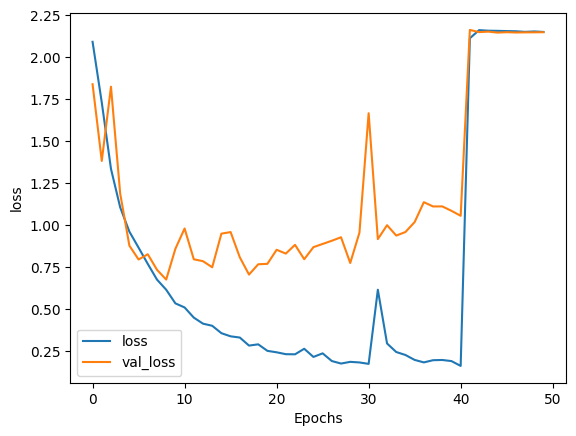

In [ ]:
plot_history(history_seq, 'loss')

In [ ]:
model_resnet,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)

Epoch 1/50
223/223 [==============================] - 5s 16ms/step - loss: 2.1211 - accuracy: 0.2162 - val_loss: 1.9866 - val_accuracy: 0.2543
Epoch 2/50
223/223 [==============================] - 3s 14ms/step - loss: 1.9256 - accuracy: 0.2952 - val_loss: 1.8488 - val_accuracy: 0.3333
Epoch 3/50
223/223 [==============================] - 3s 13ms/step - loss: 1.7968 - accuracy: 0.3501 - val_loss: 1.6890 - val_accuracy: 0.4181
Epoch 4/50
223/223 [==============================] - 3s 13ms/step - loss: 1.6415 - accuracy: 0.4297 - val_loss: 1.4330 - val_accuracy: 0.5620
Epoch 5/50
223/223 [==============================] - 3s 13ms/step - loss: 1.4669 - accuracy: 0.4890 - val_loss: 1.3297 - val_accuracy: 0.5356
Epoch 6/50
223/223 [==============================] - 3s 15ms/step - loss: 1.3374 - accuracy: 0.5426 - val_loss: 1.2840 - val_accuracy: 0.5748
Epoch 7/50
223/223 [==============================] - 3s 15ms/step - loss: 1.2273 - accuracy: 0.5744 - val_loss: 1.0308 - val_accuracy: 0.6782

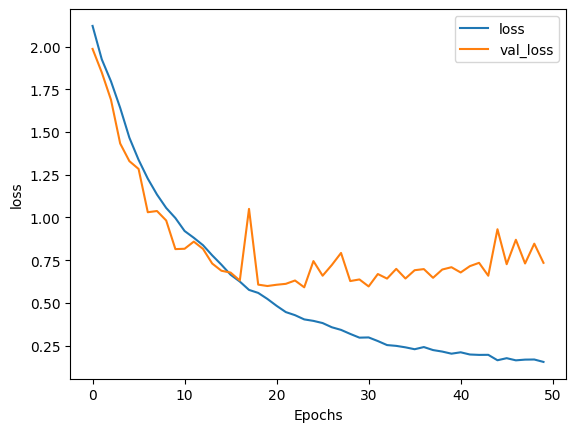

In [ ]:
plot_history(history_seq, 'loss')

In [ ]:
accuracy(model_resnet, test, label_test)[0]

67/67 [==============================] - 1s 8ms/step


0.808

67/67 [==============================] - 0s 5ms/step


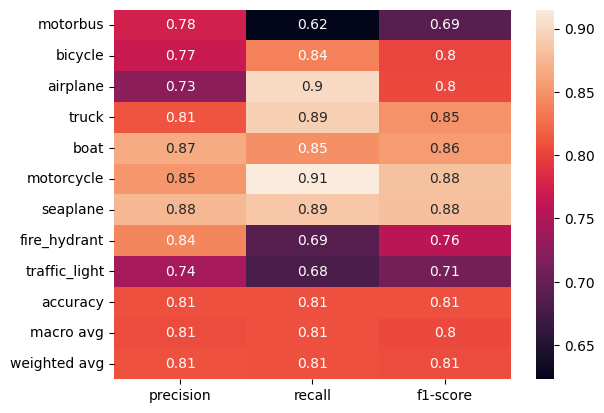

<Figure size 1000x1000 with 0 Axes>

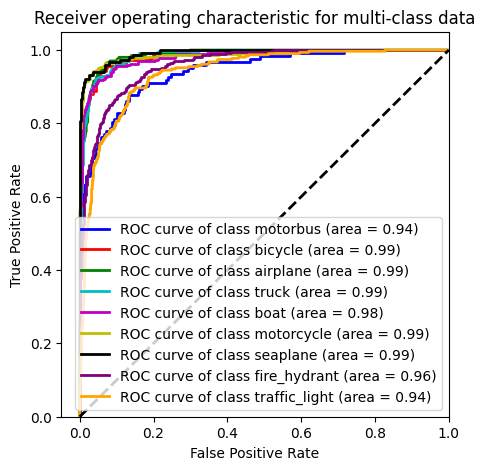

In [ ]:
auc_roc(model_resnet, test, label_test)

### Model 2 (ResNet 50)- Tried with increased height and depth

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50

def build_model_using_sequential(x_train_scaled, y_train, lr=0.01, ep=10):
    learning_rate = lr
    epp = ep
    batch_s = 28

    # Create a Sequential model
    model = Sequential()

    # Add ResNet50 base layers (excluding the top classification layers)
    base_model = ResNet50(include_top=False, weights=None, input_shape=x_train_scaled.shape[1:])
    model.add(base_model)

    # Add your custom fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(9, activation='softmax'))

    # Compile the Model
    model.compile(optimizer=SGD(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Model Training
    history = model.fit(x_train_scaled,
                        y_train,
                        epochs=epp,
                        validation_split=0.2,
                        batch_size=batch_s,
                        verbose=1)

    return model, history


In [2]:
model_resnet,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)

NameError: name 'build_model_using_sequential' is not defined

67/67 [==============================] - 0s 7ms/step


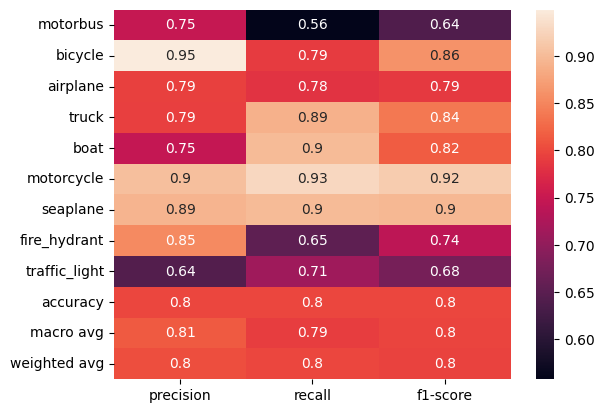

<Figure size 1000x1000 with 0 Axes>

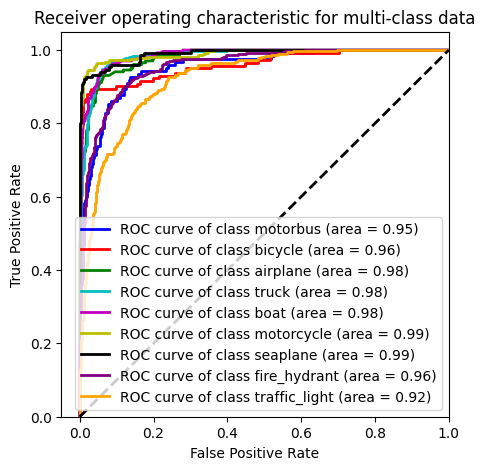

(0.798, None)

In [ ]:
plot_history(history_seq, 'loss')
accuracy(model_resnet, test, label_test)[0], auc_roc(model_seq, test, label_test)

### Model 3 - Tried with increased height

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer=SGD(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.2,
                      batch_size=batch_s,
                      verbose=1
                      # callbacks=[callback]
                      )

  return model,history

In [ ]:
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)

Epoch 1/50
223/223 [==============================] - 7s 26ms/step - loss: 2.1011 - accuracy: 0.2054 - val_loss: 1.9660 - val_accuracy: 0.2775
Epoch 2/50
223/223 [==============================] - 5s 21ms/step - loss: 1.9112 - accuracy: 0.2863 - val_loss: 1.7717 - val_accuracy: 0.3455
Epoch 3/50
223/223 [==============================] - 4s 20ms/step - loss: 1.6438 - accuracy: 0.4110 - val_loss: 1.3650 - val_accuracy: 0.5626
Epoch 4/50
223/223 [==============================] - 5s 22ms/step - loss: 1.4143 - accuracy: 0.5014 - val_loss: 1.2458 - val_accuracy: 0.5735
Epoch 5/50
223/223 [==============================] - 4s 20ms/step - loss: 1.2706 - accuracy: 0.5553 - val_loss: 1.7042 - val_accuracy: 0.4631
Epoch 6/50
223/223 [==============================] - 5s 21ms/step - loss: 1.1264 - accuracy: 0.6138 - val_loss: 0.9247 - val_accuracy: 0.6956
Epoch 7/50
223/223 [==============================] - 5s 22ms/step - loss: 1.0049 - accuracy: 0.6599 - val_loss: 0.9045 - val_accuracy: 0.6994

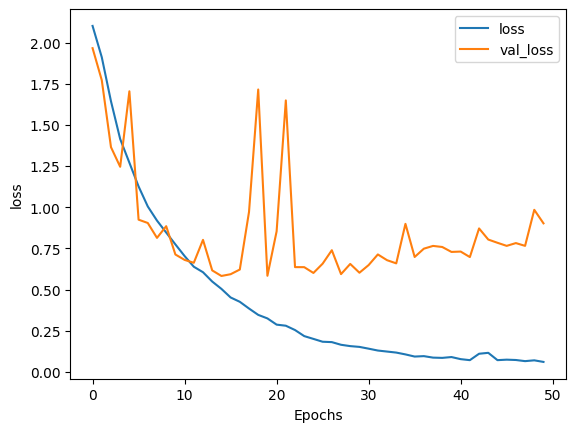

67/67 [==============================] - 1s 8ms/step


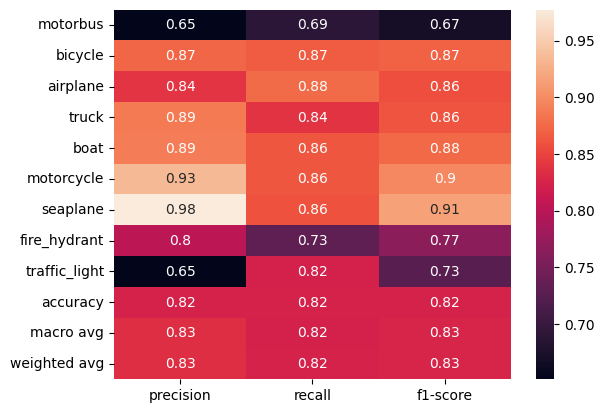

<Figure size 1000x1000 with 0 Axes>

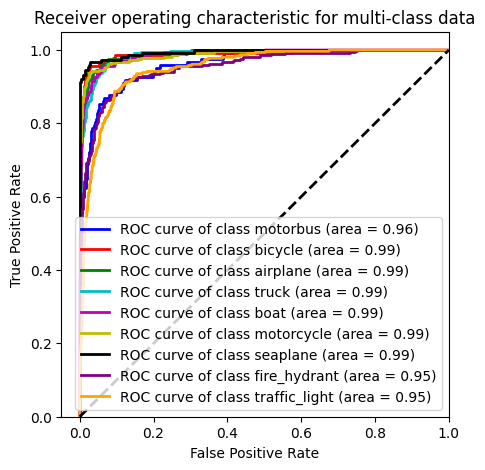

(0.824, None)

In [ ]:
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

### Model 4 -  Tried with increased depth

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(16, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(16, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer=SGD(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.2,
                      batch_size=batch_s,
                      verbose=1
                      # callbacks=[callback]
                      )

  return model,history

In [ ]:
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)

Epoch 1/50
223/223 [==============================] - 7s 18ms/step - loss: 2.1815 - accuracy: 0.2001 - val_loss: 2.1676 - val_accuracy: 0.2068
Epoch 2/50
223/223 [==============================] - 3s 15ms/step - loss: 2.1417 - accuracy: 0.2337 - val_loss: 2.1009 - val_accuracy: 0.2601
Epoch 3/50
223/223 [==============================] - 3s 13ms/step - loss: 2.0601 - accuracy: 0.2436 - val_loss: 1.9939 - val_accuracy: 0.2241
Epoch 4/50
223/223 [==============================] - 3s 13ms/step - loss: 1.9493 - accuracy: 0.2825 - val_loss: 1.9454 - val_accuracy: 0.2543
Epoch 5/50
223/223 [==============================] - 3s 13ms/step - loss: 1.8536 - accuracy: 0.3148 - val_loss: 1.8439 - val_accuracy: 0.2884
Epoch 6/50
223/223 [==============================] - 3s 14ms/step - loss: 1.7868 - accuracy: 0.3453 - val_loss: 1.6651 - val_accuracy: 0.4181
Epoch 7/50
223/223 [==============================] - 3s 13ms/step - loss: 1.7089 - accuracy: 0.3806 - val_loss: 1.6121 - val_accuracy: 0.4374

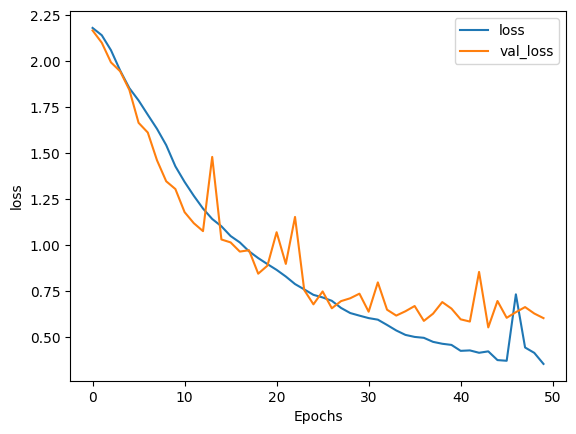

67/67 [==============================] - 0s 5ms/step


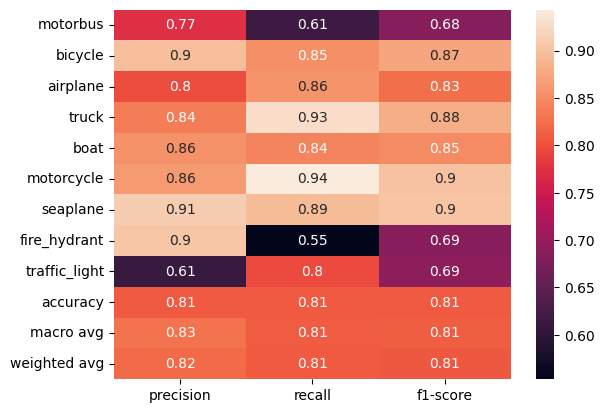

<Figure size 1000x1000 with 0 Axes>

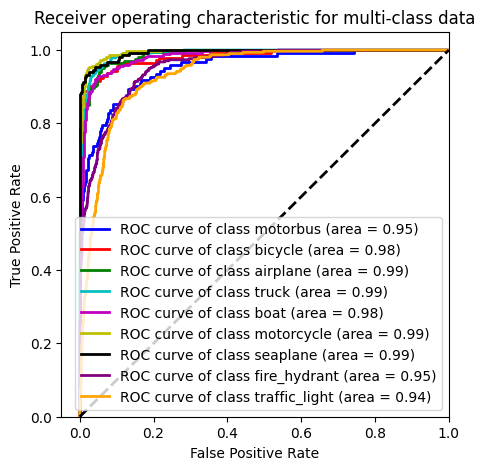

(0.809, None)

In [ ]:
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

### Model 5 - with different activation functions

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='sigmoid'),
    Dropout(0.1),
    keras.layers.Dense(32, activation='sigmoid'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer=SGD(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.2,
                      batch_size=batch_s,
                      verbose=1,
                      callbacks=[callback]
                      )

  return model,history

In [ ]:
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 100)

Epoch 1/100
223/223 [==============================] - 9s 36ms/step - loss: 2.1874 - accuracy: 0.1449 - val_loss: 2.1417 - val_accuracy: 0.1663
Epoch 2/100
223/223 [==============================] - 7s 32ms/step - loss: 2.1566 - accuracy: 0.1538 - val_loss: 2.1304 - val_accuracy: 0.1663
Epoch 3/100
223/223 [==============================] - 7s 33ms/step - loss: 2.1352 - accuracy: 0.1819 - val_loss: 2.1027 - val_accuracy: 0.2132
Epoch 4/100
223/223 [==============================] - 7s 32ms/step - loss: 2.0915 - accuracy: 0.2198 - val_loss: 2.0466 - val_accuracy: 0.2672
Epoch 5/100
223/223 [==============================] - 7s 33ms/step - loss: 2.0335 - accuracy: 0.2515 - val_loss: 1.9913 - val_accuracy: 0.2864
Epoch 6/100
223/223 [==============================] - 7s 31ms/step - loss: 1.9796 - accuracy: 0.2687 - val_loss: 1.9712 - val_accuracy: 0.3070
Epoch 7/100
223/223 [==============================] - 7s 33ms/step - loss: 1.9382 - accuracy: 0.2825 - val_loss: 1.9208 - val_accuracy:

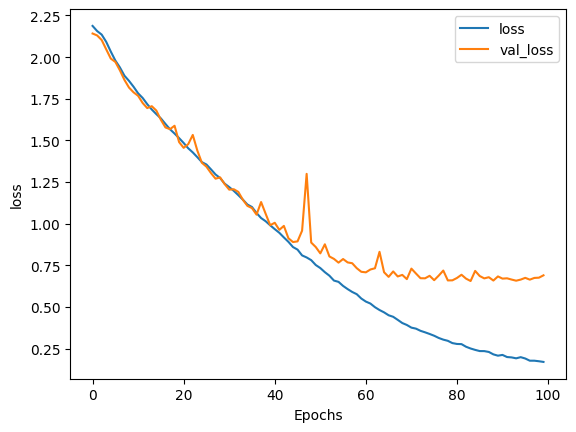

67/67 [==============================] - 1s 9ms/step


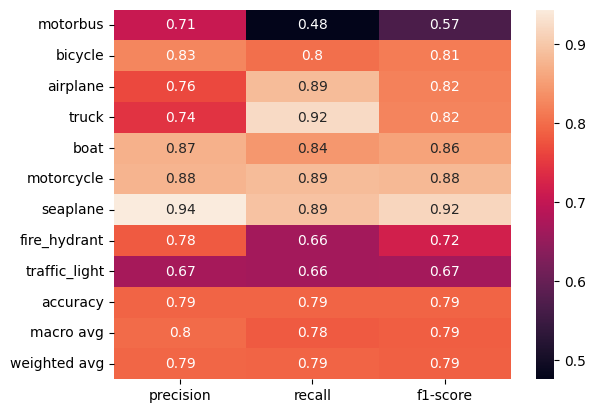

<Figure size 1000x1000 with 0 Axes>

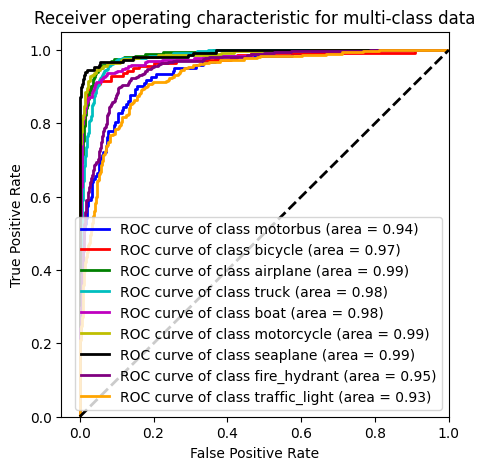

(0.791, None)

In [ ]:
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

Epoch 1/50
223/223 [==============================] - 9s 35ms/step - loss: 1.8396 - accuracy: 0.3523 - val_loss: 1.6024 - val_accuracy: 0.4534
Epoch 2/50
223/223 [==============================] - 7s 32ms/step - loss: 1.3886 - accuracy: 0.5502 - val_loss: 1.3187 - val_accuracy: 0.5896
Epoch 3/50
223/223 [==============================] - 7s 32ms/step - loss: 1.1712 - accuracy: 0.6316 - val_loss: 1.2200 - val_accuracy: 0.5800
Epoch 4/50
223/223 [==============================] - 7s 32ms/step - loss: 1.0124 - accuracy: 0.6835 - val_loss: 1.1476 - val_accuracy: 0.6204
Epoch 5/50
223/223 [==============================] - 7s 32ms/step - loss: 0.8920 - accuracy: 0.7162 - val_loss: 0.8431 - val_accuracy: 0.7354
Epoch 6/50
223/223 [==============================] - 7s 33ms/step - loss: 0.7789 - accuracy: 0.7565 - val_loss: 0.9097 - val_accuracy: 0.7013
Epoch 7/50
223/223 [==============================] - 7s 31ms/step - loss: 0.6951 - accuracy: 0.7855 - val_loss: 0.6971 - val_accuracy: 0.7714

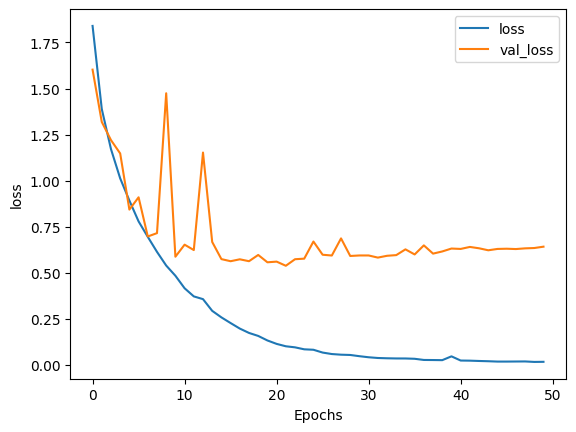

67/67 [==============================] - 1s 16ms/step


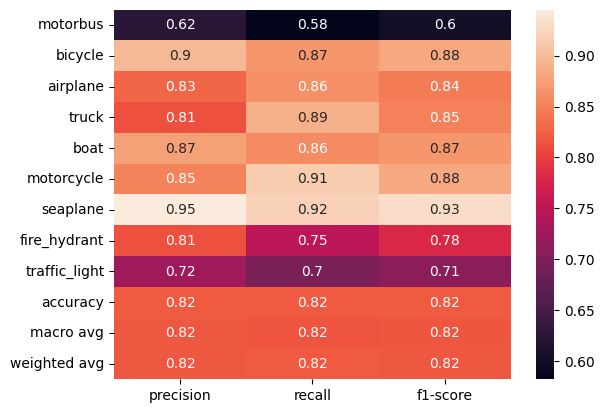

<Figure size 1000x1000 with 0 Axes>

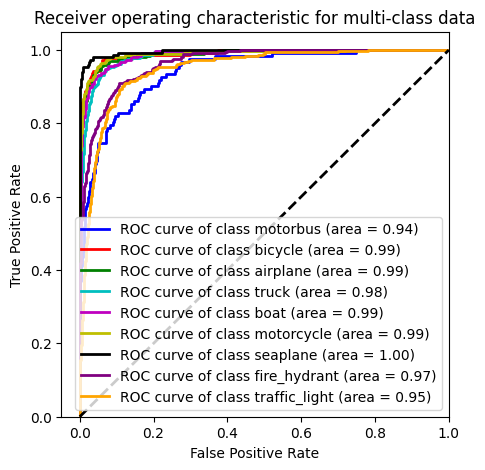

(0.819, None)

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='tanh'),
    Dropout(0.1),
    keras.layers.Dense(32, activation='tanh'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer=SGD(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.2,
                      batch_size=batch_s,
                      verbose=1,
                      callbacks=[callback]
                      )

  return model,history

model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

### Model

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=3,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.15,
                      batch_size=batch_s,
                      verbose=1,
                      callbacks=[callback]
                      )

  return model,history

Epoch 1/50
237/237 [==============================] - 12s 42ms/step - loss: 1.3503 - accuracy: 0.5293 - val_loss: 0.8430 - val_accuracy: 0.7175
Epoch 2/50
237/237 [==============================] - 9s 39ms/step - loss: 0.7299 - accuracy: 0.7506 - val_loss: 0.5820 - val_accuracy: 0.8108
Epoch 3/50
237/237 [==============================] - 9s 38ms/step - loss: 0.5014 - accuracy: 0.8292 - val_loss: 0.5267 - val_accuracy: 0.8228
Epoch 4/50
237/237 [==============================] - 9s 38ms/step - loss: 0.3595 - accuracy: 0.8773 - val_loss: 0.6659 - val_accuracy: 0.8116
Epoch 5/50
237/237 [==============================] - 9s 39ms/step - loss: 0.2966 - accuracy: 0.9040 - val_loss: 0.5675 - val_accuracy: 0.8313
Epoch 6/50
237/237 [==============================] - 10s 43ms/step - loss: 0.2188 - accuracy: 0.9259 - val_loss: 0.6332 - val_accuracy: 0.8211
Epoch 6: early stopping


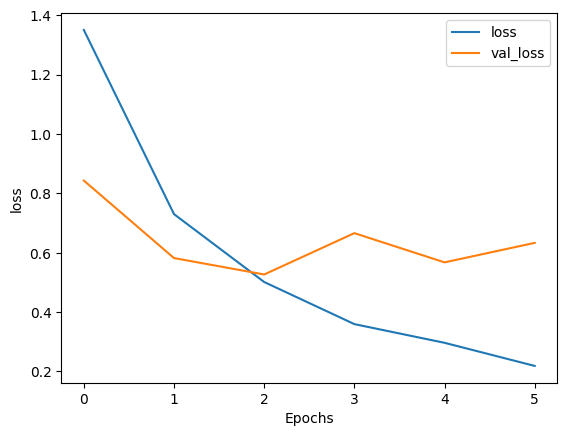

67/67 [==============================] - 1s 13ms/step


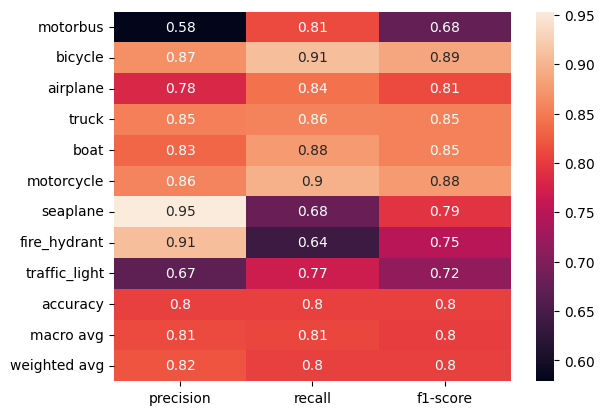

<Figure size 1000x1000 with 0 Axes>

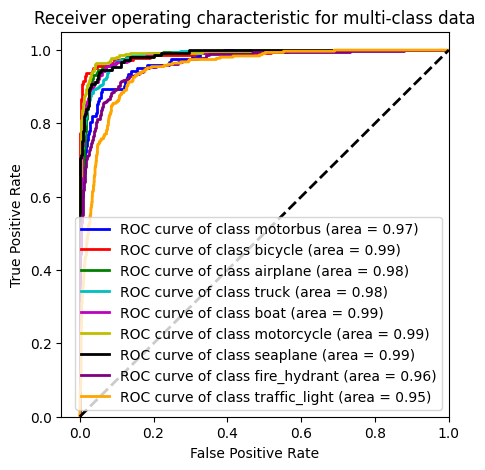

(0.804, None)

In [ ]:
# callback 5
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
import pickle

pickle_out = open("model1.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model_seq, pickle_out)
pickle_out.close()

Epoch 1/50
237/237 [==============================] - 14s 43ms/step - loss: 1.4933 - accuracy: 0.4784 - val_loss: 0.7646 - val_accuracy: 0.7432
Epoch 2/50
237/237 [==============================] - 9s 38ms/step - loss: 0.8167 - accuracy: 0.7163 - val_loss: 0.6461 - val_accuracy: 0.7868
Epoch 3/50
237/237 [==============================] - 9s 39ms/step - loss: 0.6173 - accuracy: 0.7901 - val_loss: 0.5568 - val_accuracy: 0.8142
Epoch 4/50
237/237 [==============================] - 9s 39ms/step - loss: 0.4508 - accuracy: 0.8445 - val_loss: 0.5825 - val_accuracy: 0.8322
Epoch 5/50
237/237 [==============================] - 9s 38ms/step - loss: 0.3936 - accuracy: 0.8629 - val_loss: 0.5527 - val_accuracy: 0.8313
Epoch 6/50
237/237 [==============================] - 9s 39ms/step - loss: 0.3067 - accuracy: 0.8946 - val_loss: 0.5929 - val_accuracy: 0.8279
Epoch 7/50
237/237 [==============================] - 9s 38ms/step - loss: 0.2502 - accuracy: 0.9138 - val_loss: 0.6033 - val_accuracy: 0.829

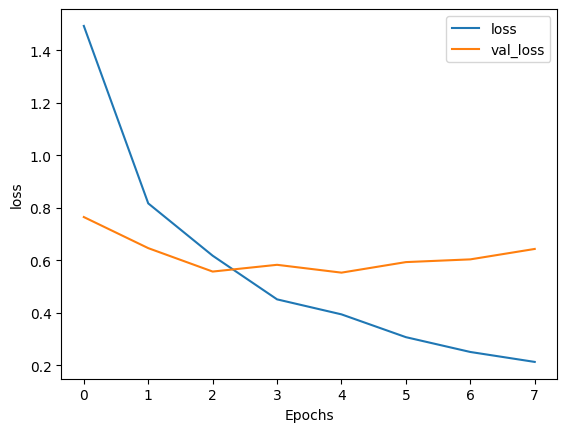

67/67 [==============================] - 1s 12ms/step


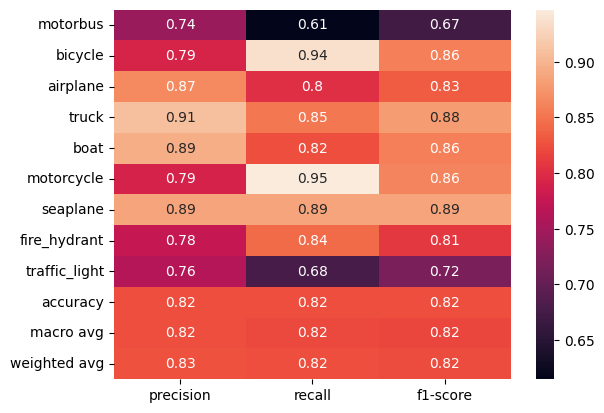

<Figure size 1000x1000 with 0 Axes>

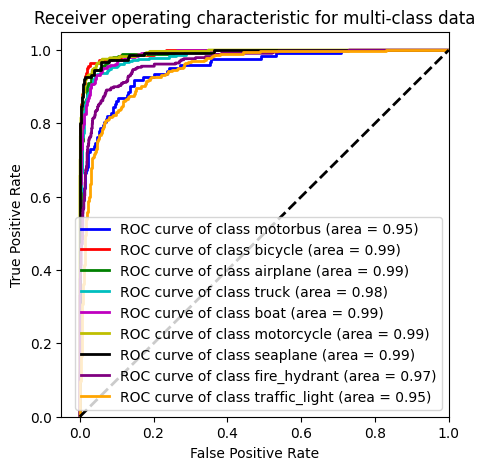

(0.824, None)

In [ ]:
# callback 5
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.001, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
import pickle

pickle_out = open("model2.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model_seq, pickle_out)
pickle_out.close()

Epoch 1/50
237/237 [==============================] - 12s 39ms/step - loss: 1.3904 - accuracy: 0.5186 - val_loss: 0.8257 - val_accuracy: 0.7183
Epoch 2/50
237/237 [==============================] - 10s 42ms/step - loss: 0.7841 - accuracy: 0.7266 - val_loss: 0.6672 - val_accuracy: 0.7860
Epoch 3/50
237/237 [==============================] - 9s 38ms/step - loss: 0.5877 - accuracy: 0.7964 - val_loss: 0.6487 - val_accuracy: 0.7902
Epoch 4/50
237/237 [==============================] - 9s 37ms/step - loss: 0.4718 - accuracy: 0.8395 - val_loss: 0.5766 - val_accuracy: 0.8108
Epoch 5/50
237/237 [==============================] - 9s 37ms/step - loss: 0.3769 - accuracy: 0.8727 - val_loss: 0.5011 - val_accuracy: 0.8373
Epoch 6/50
237/237 [==============================] - 9s 37ms/step - loss: 0.2998 - accuracy: 0.8983 - val_loss: 0.4991 - val_accuracy: 0.8228
Epoch 7/50
237/237 [==============================] - 9s 36ms/step - loss: 0.2582 - accuracy: 0.9163 - val_loss: 0.5654 - val_accuracy: 0.83

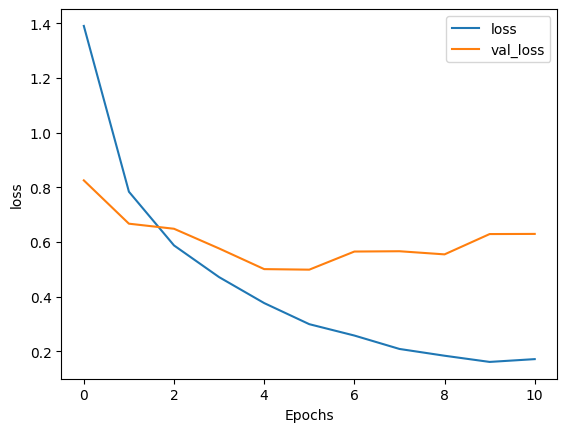

67/67 [==============================] - 1s 12ms/step


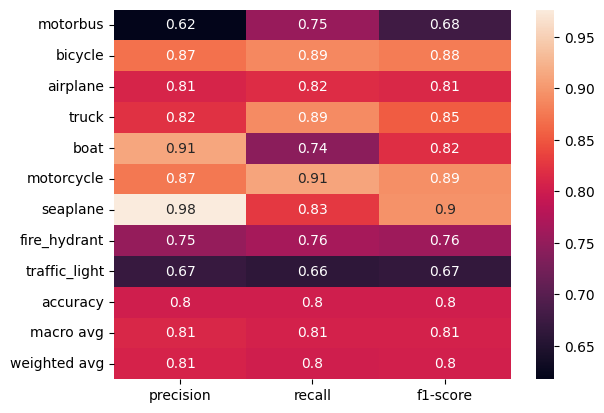

<Figure size 1000x1000 with 0 Axes>

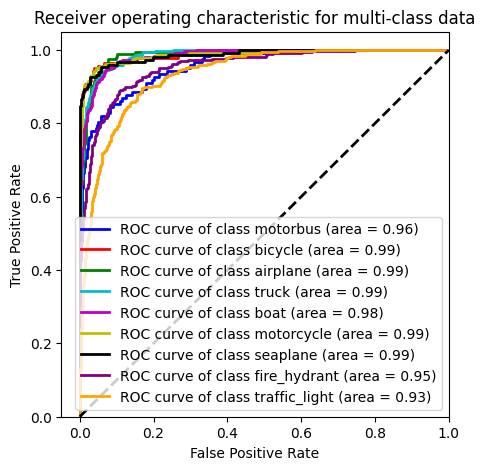

(0.802, None)

In [ ]:
# callback 5
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.001, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

Epoch 1/50
237/237 [==============================] - 12s 40ms/step - loss: 1.5509 - accuracy: 0.4489 - val_loss: 1.0165 - val_accuracy: 0.6455
Epoch 2/50
237/237 [==============================] - 9s 37ms/step - loss: 0.9599 - accuracy: 0.6593 - val_loss: 0.7561 - val_accuracy: 0.7457
Epoch 3/50
237/237 [==============================] - 9s 37ms/step - loss: 0.7408 - accuracy: 0.7441 - val_loss: 0.6561 - val_accuracy: 0.7731
Epoch 4/50
237/237 [==============================] - 9s 38ms/step - loss: 0.6270 - accuracy: 0.7795 - val_loss: 0.5792 - val_accuracy: 0.7971
Epoch 5/50
237/237 [==============================] - 11s 47ms/step - loss: 0.5044 - accuracy: 0.8245 - val_loss: 0.5796 - val_accuracy: 0.8091
Epoch 6/50
237/237 [==============================] - 10s 41ms/step - loss: 0.4352 - accuracy: 0.8505 - val_loss: 0.5734 - val_accuracy: 0.7988
Epoch 7/50
237/237 [==============================] - 9s 37ms/step - loss: 0.3675 - accuracy: 0.8723 - val_loss: 0.5787 - val_accuracy: 0.8

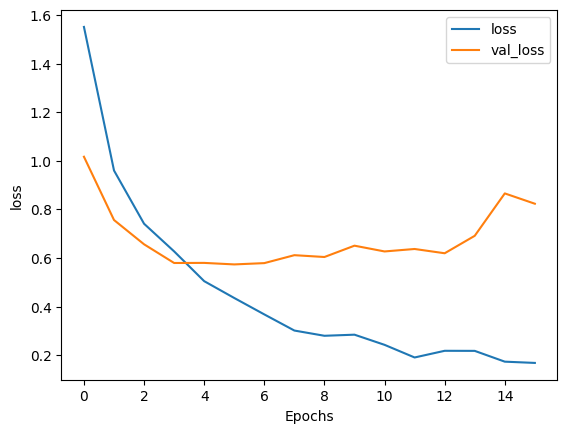

67/67 [==============================] - 1s 11ms/step


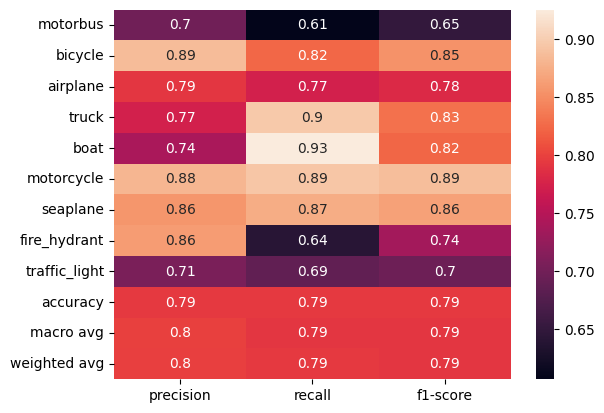

<Figure size 1000x1000 with 0 Axes>

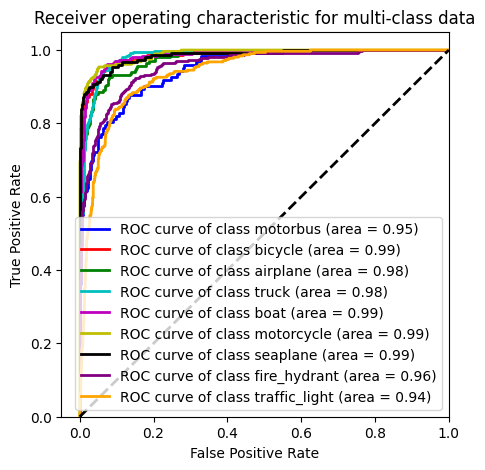

(0.794, None)

In [ ]:
# callback 10
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

### Model

In [ ]:
adamax = tf.keras.optimizers.Adamax(learning_rate=0.001,
                                   beta_1=0.9,
                                   beta_2=0.999,
                                   epsilon=1e-07,
                                   name='Adamax')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=3,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer=adamax,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.15,
                      batch_size=batch_s,
                      verbose=1,
                      callbacks=[callback]
                      )

  return model,history

Epoch 1/50
237/237 [==============================] - 24s 45ms/step - loss: 1.5595 - accuracy: 0.4556 - val_loss: 1.0062 - val_accuracy: 0.6781
Epoch 2/50
237/237 [==============================] - 10s 41ms/step - loss: 0.9498 - accuracy: 0.6808 - val_loss: 0.6521 - val_accuracy: 0.7945
Epoch 3/50
237/237 [==============================] - 9s 39ms/step - loss: 0.7500 - accuracy: 0.7464 - val_loss: 0.6259 - val_accuracy: 0.7954
Epoch 4/50
237/237 [==============================] - 9s 39ms/step - loss: 0.5918 - accuracy: 0.8005 - val_loss: 0.5239 - val_accuracy: 0.8313
Epoch 5/50
237/237 [==============================] - 9s 39ms/step - loss: 0.4998 - accuracy: 0.8362 - val_loss: 0.5419 - val_accuracy: 0.8253
Epoch 6/50
237/237 [==============================] - 9s 39ms/step - loss: 0.4271 - accuracy: 0.8573 - val_loss: 0.4652 - val_accuracy: 0.8502
Epoch 7/50
237/237 [==============================] - 9s 39ms/step - loss: 0.3678 - accuracy: 0.8854 - val_loss: 0.4708 - val_accuracy: 0.84

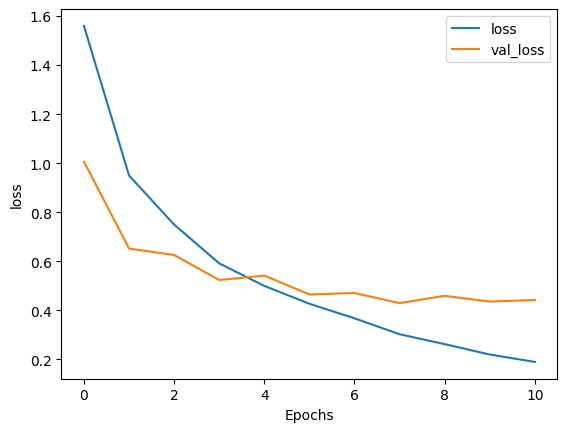

67/67 [==============================] - 1s 12ms/step


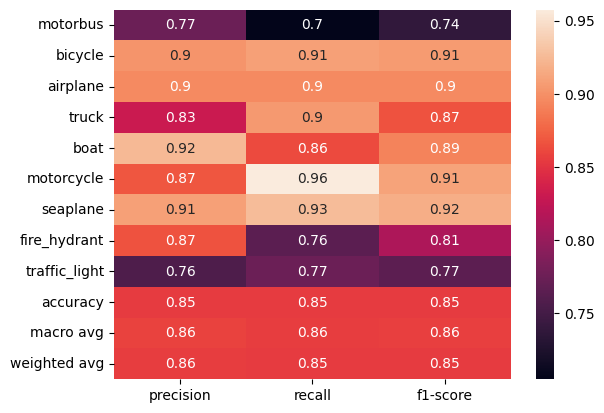

<Figure size 1000x1000 with 0 Axes>

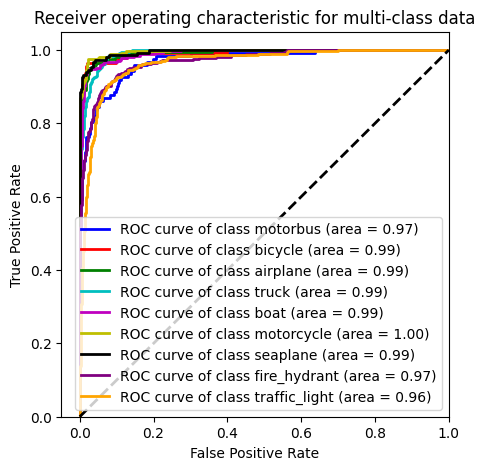

(0.855, None)

In [ ]:
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
import pickle

pickle_out = open("model4.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model_seq, pickle_out)
pickle_out.close()

Epoch 1/50
237/237 [==============================] - 12s 40ms/step - loss: 1.4294 - accuracy: 0.5113 - val_loss: 0.8279 - val_accuracy: 0.7414
Epoch 2/50
237/237 [==============================] - 9s 39ms/step - loss: 0.8779 - accuracy: 0.6989 - val_loss: 0.7676 - val_accuracy: 0.7534
Epoch 3/50
237/237 [==============================] - 9s 39ms/step - loss: 0.6988 - accuracy: 0.7656 - val_loss: 0.5448 - val_accuracy: 0.8236
Epoch 4/50
237/237 [==============================] - 9s 37ms/step - loss: 0.5693 - accuracy: 0.8073 - val_loss: 0.5213 - val_accuracy: 0.8236
Epoch 5/50
237/237 [==============================] - 9s 38ms/step - loss: 0.4817 - accuracy: 0.8359 - val_loss: 0.4766 - val_accuracy: 0.8459
Epoch 6/50
237/237 [==============================] - 9s 38ms/step - loss: 0.4059 - accuracy: 0.8635 - val_loss: 0.4729 - val_accuracy: 0.8399
Epoch 7/50
237/237 [==============================] - 9s 37ms/step - loss: 0.3404 - accuracy: 0.8865 - val_loss: 0.4726 - val_accuracy: 0.843

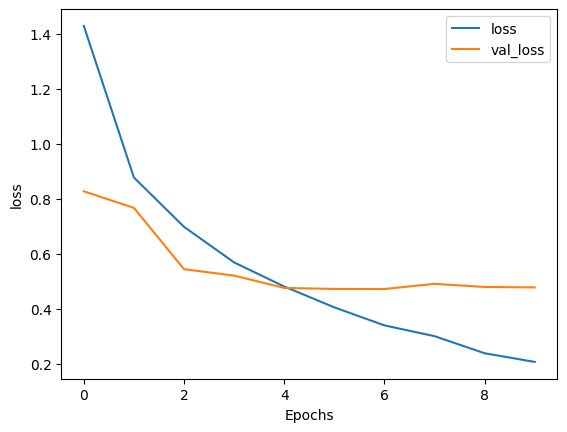

67/67 [==============================] - 1s 11ms/step


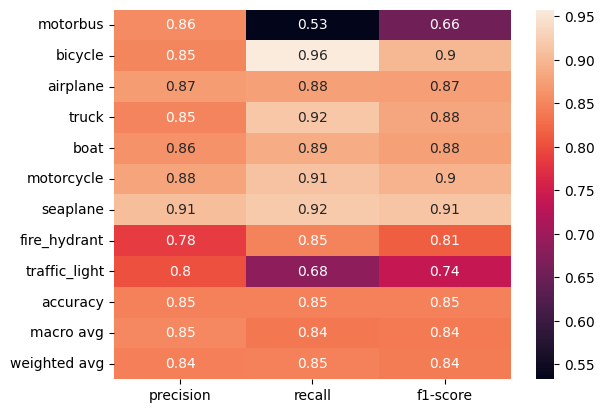

<Figure size 1000x1000 with 0 Axes>

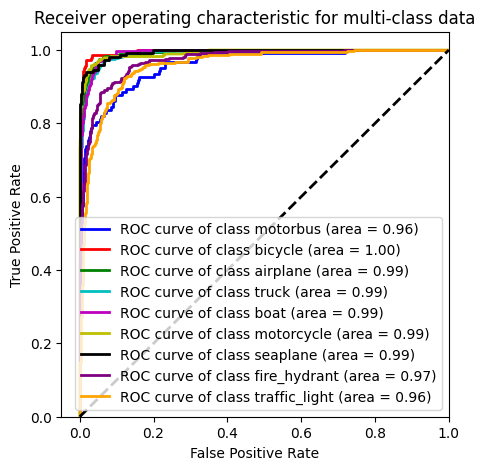

(0.845, None)

In [ ]:
# callback 10
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.001, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
import pickle

pickle_out = open("model5.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model_seq, pickle_out)
pickle_out.close()

In [ ]:
adamax = tf.keras.optimizers.Adamax(learning_rate=0.001,
                                   beta_1=0.9,
                                   beta_2=0.999,
                                   epsilon=1e-07,
                                   name='Adamax')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=3,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(256, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(256, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(128, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer=adamax,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.15,
                      batch_size=batch_s,
                      verbose=1,
                      callbacks=[callback]
                      )

  return model,history

Epoch 1/50
237/237 [==============================] - 28s 98ms/step - loss: 1.3040 - accuracy: 0.5538 - val_loss: 0.8122 - val_accuracy: 0.7312
Epoch 2/50
237/237 [==============================] - 21s 87ms/step - loss: 0.7035 - accuracy: 0.7609 - val_loss: 0.5852 - val_accuracy: 0.7971
Epoch 3/50
237/237 [==============================] - 20s 86ms/step - loss: 0.5303 - accuracy: 0.8168 - val_loss: 0.5045 - val_accuracy: 0.8313
Epoch 4/50
237/237 [==============================] - 20s 85ms/step - loss: 0.4193 - accuracy: 0.8597 - val_loss: 0.4578 - val_accuracy: 0.8510
Epoch 5/50
237/237 [==============================] - 20s 85ms/step - loss: 0.3274 - accuracy: 0.8897 - val_loss: 0.5026 - val_accuracy: 0.8279
Epoch 6/50
237/237 [==============================] - 20s 85ms/step - loss: 0.2610 - accuracy: 0.9102 - val_loss: 0.4496 - val_accuracy: 0.8570
Epoch 7/50
237/237 [==============================] - 20s 86ms/step - loss: 0.2143 - accuracy: 0.9288 - val_loss: 0.4448 - val_accuracy:

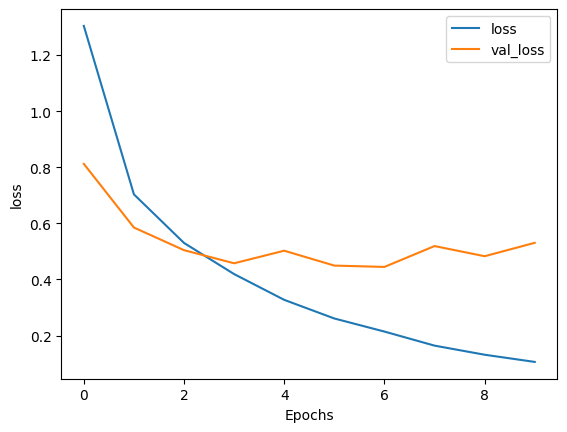

67/67 [==============================] - 2s 26ms/step


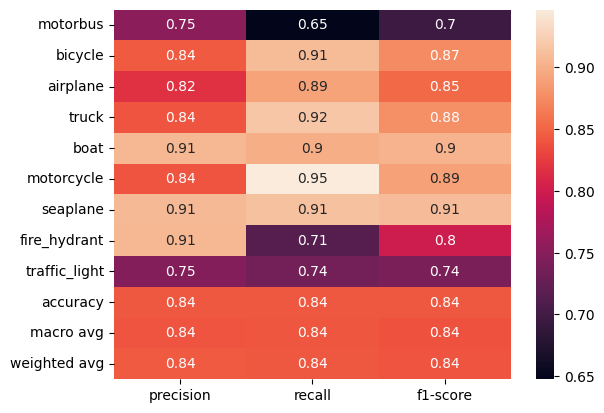

<Figure size 1000x1000 with 0 Axes>

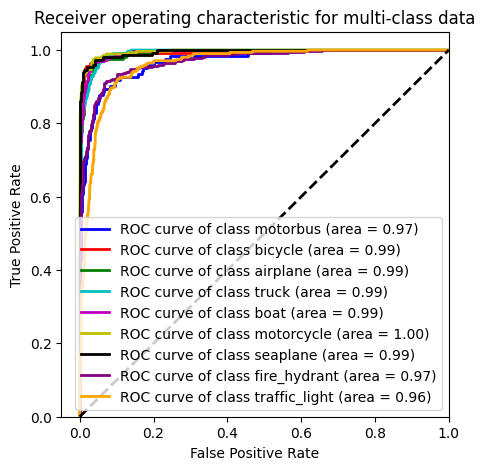

(0.842, None)

In [ ]:
# callback 10
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.01, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
import pickle

pickle_out = open("model7.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model_seq, pickle_out)
pickle_out.close()

Epoch 1/50
237/237 [==============================] - 37s 98ms/step - loss: 1.3713 - accuracy: 0.5388 - val_loss: 0.7509 - val_accuracy: 0.7551
Epoch 2/50
237/237 [==============================] - 21s 88ms/step - loss: 0.7058 - accuracy: 0.7613 - val_loss: 0.5290 - val_accuracy: 0.8228
Epoch 3/50
237/237 [==============================] - 20s 86ms/step - loss: 0.5185 - accuracy: 0.8226 - val_loss: 0.5032 - val_accuracy: 0.8305
Epoch 4/50
237/237 [==============================] - 21s 87ms/step - loss: 0.3969 - accuracy: 0.8674 - val_loss: 0.5231 - val_accuracy: 0.8330
Epoch 5/50
237/237 [==============================] - 21s 87ms/step - loss: 0.2967 - accuracy: 0.9004 - val_loss: 0.4536 - val_accuracy: 0.8425
Epoch 6/50
237/237 [==============================] - 21s 87ms/step - loss: 0.2346 - accuracy: 0.9220 - val_loss: 0.4367 - val_accuracy: 0.8639
Epoch 7/50
237/237 [==============================] - 21s 87ms/step - loss: 0.1841 - accuracy: 0.9365 - val_loss: 0.4707 - val_accuracy:

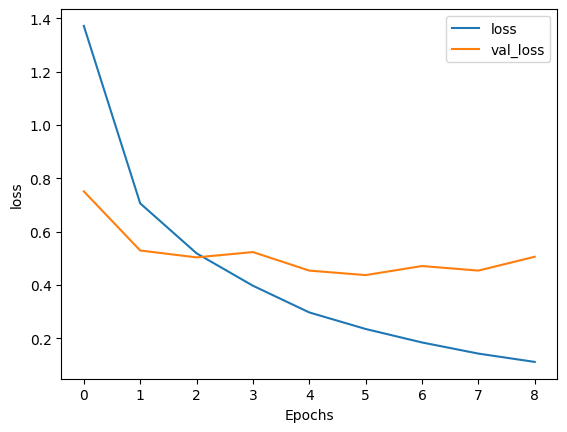

67/67 [==============================] - 2s 25ms/step


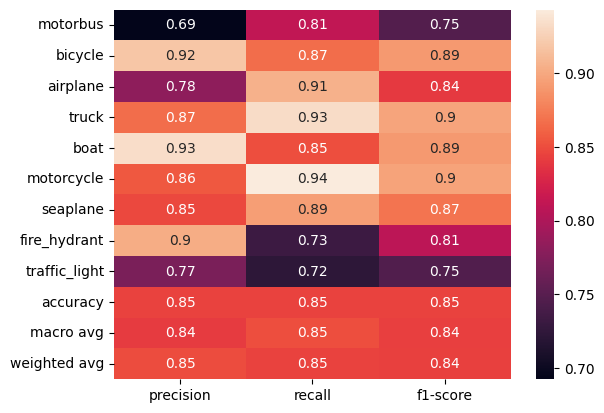

<Figure size 1000x1000 with 0 Axes>

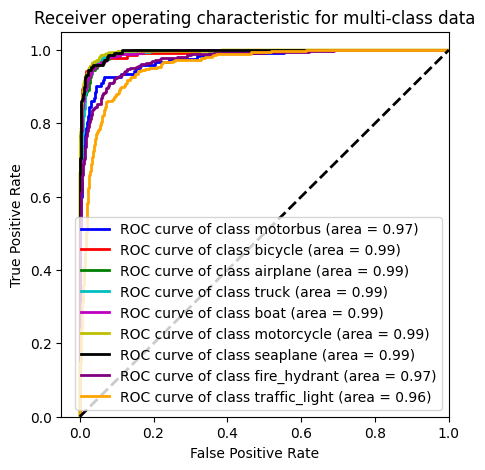

(0.845, None)

In [ ]:
# callbac
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.025, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
import pickle

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/data/Captcha Image/model8.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model_seq, pickle_out)
pickle_out.close()

Epoch 1/50
237/237 [==============================] - 23s 89ms/step - loss: 1.4351 - accuracy: 0.5231 - val_loss: 0.8686 - val_accuracy: 0.7106
Epoch 2/50
237/237 [==============================] - 20s 86ms/step - loss: 0.8273 - accuracy: 0.7186 - val_loss: 0.7112 - val_accuracy: 0.7620
Epoch 3/50
237/237 [==============================] - 20s 85ms/step - loss: 0.6365 - accuracy: 0.7813 - val_loss: 0.6441 - val_accuracy: 0.7860
Epoch 4/50
237/237 [==============================] - 20s 86ms/step - loss: 0.5078 - accuracy: 0.8262 - val_loss: 0.5183 - val_accuracy: 0.8159
Epoch 5/50
237/237 [==============================] - 20s 86ms/step - loss: 0.4208 - accuracy: 0.8594 - val_loss: 0.4883 - val_accuracy: 0.8330
Epoch 6/50
237/237 [==============================] - 21s 87ms/step - loss: 0.3355 - accuracy: 0.8868 - val_loss: 0.4719 - val_accuracy: 0.8408
Epoch 7/50
237/237 [==============================] - 20s 86ms/step - loss: 0.2796 - accuracy: 0.9052 - val_loss: 0.4343 - val_accuracy:

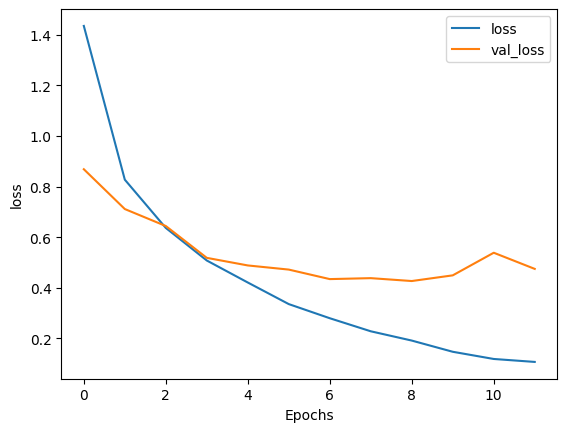

67/67 [==============================] - 2s 25ms/step


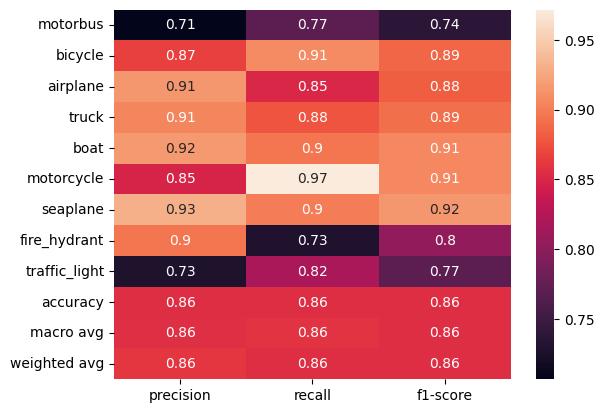

<Figure size 1000x1000 with 0 Axes>

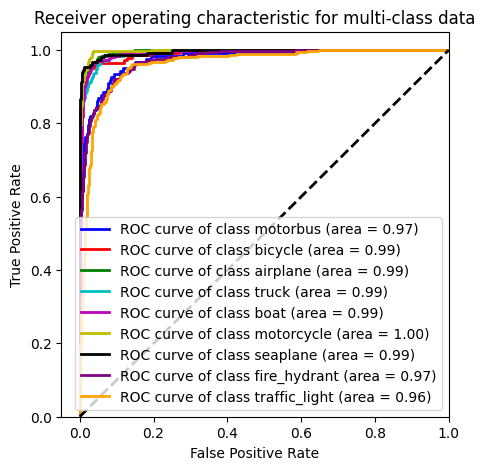

(0.855, None)

In [ ]:
# callback 10
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.015, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

In [ ]:
import pickle

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/data/Captcha Image/model6.pkl", "wb")  # wb = WRITE BYTE
pickle.dump(model_seq, pickle_out)
pickle_out.close()

In [ ]:
import pickle

### M

In [ ]:
test[0]

array([[[0.5137255 , 0.24313726, 0.16470589],
        [0.5137255 , 0.24313726, 0.16470589],
        [0.5137255 , 0.24313726, 0.16470589],
        ...,
        [0.5176471 , 0.24705882, 0.16862746],
        [0.5176471 , 0.24705882, 0.16862746],
        [0.5176471 , 0.24705882, 0.16862746]],

       [[0.5137255 , 0.24313726, 0.16470589],
        [0.5137255 , 0.24313726, 0.16470589],
        [0.5137255 , 0.24313726, 0.16470589],
        ...,
        [0.5176471 , 0.24705882, 0.16862746],
        [0.5176471 , 0.24705882, 0.16862746],
        [0.5176471 , 0.24705882, 0.16862746]],

       [[0.5137255 , 0.24313726, 0.16470589],
        [0.5137255 , 0.24313726, 0.16470589],
        [0.5137255 , 0.24313726, 0.16470589],
        ...,
        [0.5176471 , 0.24705882, 0.16862746],
        [0.5176471 , 0.24705882, 0.16862746],
        [0.5176471 , 0.24705882, 0.16862746]],

       ...,

       [[0.5294118 , 0.29411766, 0.20784314],
        [0.5294118 , 0.29411766, 0.20784314],
        [0.5254902 , 0

In [ ]:
train = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train])

In [ ]:
test = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in test]

In [ ]:
train =  np.array(train)
train.shape

(7784, 128, 128)

In [ ]:
test =  np.array(test)
test.shape

(2142, 128, 128, 1)

In [ ]:
train = np.array([img.reshape(128,128,1) for img in train])

In [ ]:
test = np.array([img.reshape(128,128,1) for img in test])

In [ ]:
adamax = tf.keras.optimizers.Adamax(learning_rate=0.1,
                                   beta_1=0.9,
                                   beta_2=0.999,
                                   epsilon=1e-07,
                                   name='Adamax')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
# Creating model using the Sequential in tensorflow

def build_model_using_sequential(x_train_scaled,y_train, lr=0.01, ep=10):
  learning_rate = lr
  epp = ep
  batch_s = 28

  model = keras.Sequential([
    layers.Conv2D(256, (3,3), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid'),
    layers.Conv2D(256, (3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.1),
    keras.layers.Dense(9, activation=tf.nn.softmax)
  ])

  # Compile the Model

  model.compile(optimizer="adamax",
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Model Training

  # train the model
  history = model.fit(x_train_scaled,
                      y_train,
                      epochs=epp,
                      validation_split=0.35,
                      batch_size=batch_s,
                      verbose=1,
                      callbacks=[callback]
                      )

  return model,history

Epoch 1/50
237/237 [==============================] - 25s 87ms/step - loss: 1.6716 - accuracy: 0.4184 - val_loss: 1.3116 - val_accuracy: 0.5771
Epoch 2/50
237/237 [==============================] - 20s 85ms/step - loss: 1.1222 - accuracy: 0.6138 - val_loss: 0.8595 - val_accuracy: 0.7046
Epoch 3/50
237/237 [==============================] - 20s 83ms/step - loss: 0.9043 - accuracy: 0.6758 - val_loss: 0.7508 - val_accuracy: 0.7474
Epoch 4/50
237/237 [==============================] - 20s 83ms/step - loss: 0.7787 - accuracy: 0.7257 - val_loss: 0.6976 - val_accuracy: 0.7560
Epoch 5/50
237/237 [==============================] - 19s 82ms/step - loss: 0.6770 - accuracy: 0.7616 - val_loss: 0.6819 - val_accuracy: 0.7705
Epoch 6/50
237/237 [==============================] - 20s 83ms/step - loss: 0.5839 - accuracy: 0.7931 - val_loss: 0.6205 - val_accuracy: 0.7962
Epoch 7/50
237/237 [==============================] - 20s 83ms/step - loss: 0.5027 - accuracy: 0.8230 - val_loss: 0.5828 - val_accuracy:

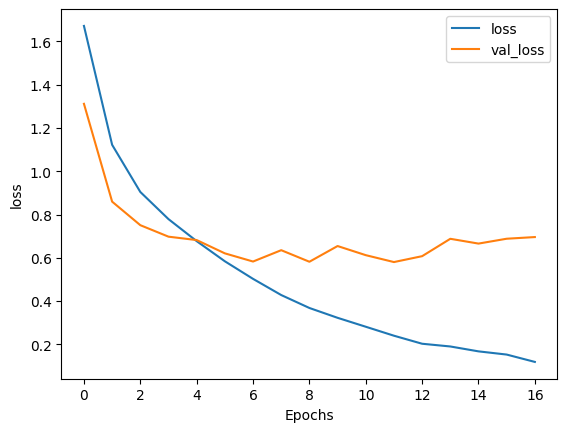

67/67 [==============================] - 2s 24ms/step


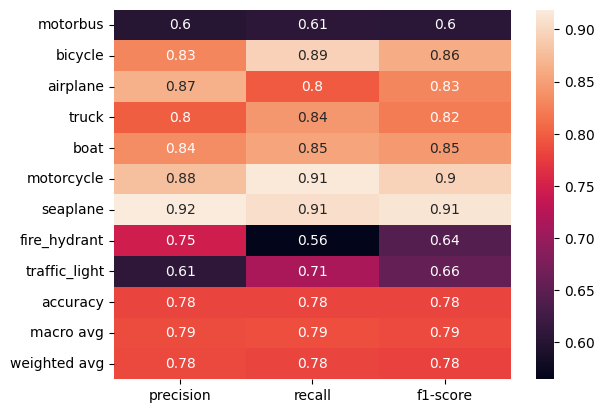

<Figure size 1000x1000 with 0 Axes>

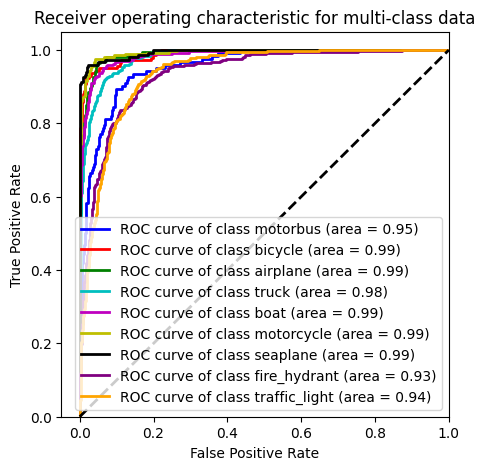

(0.781, None)

In [ ]:
model_seq,history_seq = build_model_using_sequential(train, label_train, 0.1, 50)
plot_history(history_seq, 'loss')
accuracy(model_seq, test, label_test)[0], auc_roc(model_seq, test, label_test)

### Loading Model

In [14]:
import pickle

In [86]:
pickle_in = open("Best_model.pkl", "rb")  ## rb = READ BYTE
Model = pickle.load(pickle_in)

67/67 [==============================] - 13s 192ms/step


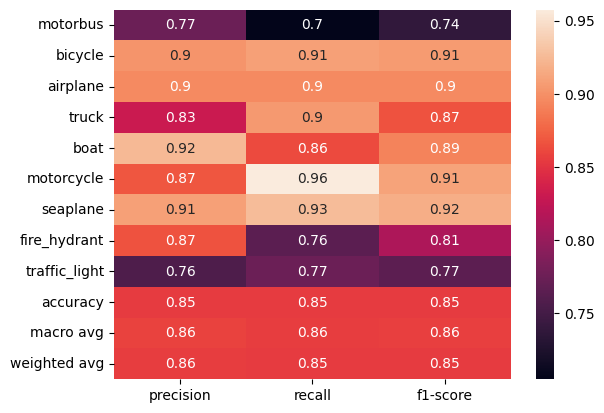

<Figure size 1000x1000 with 0 Axes>

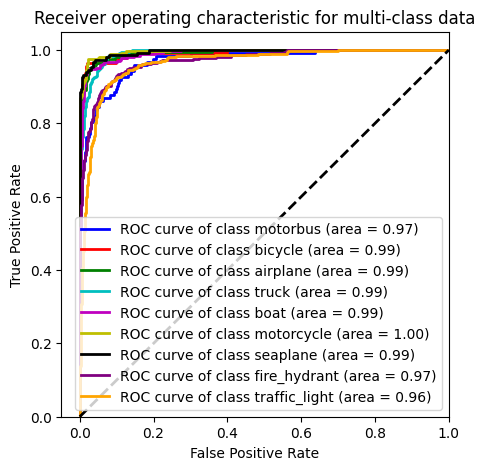

(0.855, None)

In [87]:
accuracy(Model, test, label_test)[0], auc_roc(Model, test, label_test)

In [88]:
pred = np.round(Model.predict(test),2)
out = []
for i in pred:
    maxi = np.max(i)
    x = list(np.where(i==maxi))[0][0]
    out.append(x)

res = out == label_test

67/67 [==============================] - 13s 197ms/step


In [89]:
train_categories = ['motorbus', 'bicycle', 'airplane', 'truck', 'boat', 'motorcycle', 'seaplane', 'fire_hydrant', 'traffic_light']

In [ ]:
for c in range(len(res)):
  plt.figure(figsize=(2,2))
  plt.imshow(test[c])
  plt.show()
  print(train_categories[label_test[c]],train_categories[out[c]])
  #print(t_categories[c] ,"- Shape - ", X_train[c][rn].shape)

In [98]:
npzfile = np.load('test.npz')
z = npzfile['arr_0']

In [99]:
z.shape

(9, 128, 128, 3)

In [100]:
z[0]

array([[[ 39.,  70.,  70.],
        [ 39.,  70.,  70.],
        [ 44.,  80.,  71.],
        ...,
        [ 93.,  97., 102.],
        [ 93.,  97., 102.],
        [ 84.,  91.,  97.]],

       [[ 39.,  70.,  70.],
        [ 35.,  64.,  66.],
        [ 39.,  70.,  70.],
        ...,
        [ 55.,  64.,  74.],
        [ 55.,  64.,  74.],
        [ 49.,  56.,  60.]],

       [[ 35.,  64.,  66.],
        [ 35.,  64.,  66.],
        [ 35.,  64.,  66.],
        ...,
        [ 49.,  56.,  60.],
        [ 46.,  50.,  57.],
        [ 34.,  37.,  45.]],

       ...,

       [[101.,  95.,  95.],
        [ 96.,  89.,  91.],
        [ 92.,  90.,  87.],
        ...,
        [101.,  95.,  95.],
        [101.,  95.,  95.],
        [108., 103.,  99.]],

       [[ 96.,  89.,  91.],
        [ 96.,  89.,  91.],
        [ 96.,  89.,  91.],
        ...,
        [108., 103.,  99.],
        [108., 103.,  99.],
        [108., 103.,  99.]],

       [[ 92.,  90.,  87.],
        [ 92.,  90.,  87.],
        [ 96.,  

In [101]:
def print_images(images, out):
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.flatten()
    for i in range(9):
        rnd = random.randint(0,len(res))
        axes[i].imshow(images[rnd])
        axes[i].axis('off')
        print(cat[out[rnd]])
    plt.tight_layout()
    plt.show()

In [102]:
cat = ['motorbus', 'bicycle', 'airplane', 'truck', 'boat', 'motorcycle', 'seaplane', 'fire_hydrant', 'traffic_light']

motorcycle
motorbus
truck
fire_hydrant
truck
fire_hydrant
truck
fire_hydrant
motorbus


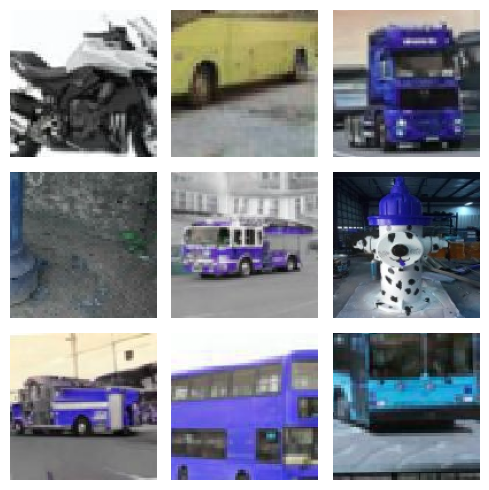

(None,)

In [103]:
print_images(test, out), 

In [104]:
z = z/255

In [105]:
pred2 = np.round(Model.predict(z), 2)
out2 = []
for i in pred2:
    maxi = np.max(i)
    x = list(np.where(i==maxi))[0][0]
    out2.append(x)

# res2 = out2 == label_test

1/1 [==============================] - 0s 67ms/step


motorbus
motorbus
airplane
motorcycle
traffic_light
motorcycle
fire_hydrant
traffic_light
motorcycle


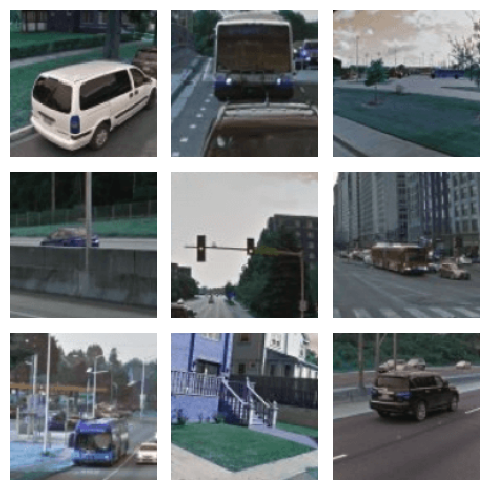

In [106]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.flatten()
for i in range(9):
        axes[i].imshow(z[i])
        axes[i].axis('off')
        print(cat[out2[i]])
plt.tight_layout()
plt.show()

In [155]:
def format(images):
    height = 128
    rgb = np.ones((height*3, height*3, 3))
    bgr = np.ones((height*3, height*3, 3))
    r = []
    for i in range(3):
        for j in range(3):
            rnd = random.randint(0,len(test))
            r.append(rnd)
            rgb[(height*i):(height*(i+1)), height*j:height*(j+1), : ] = cv2.cvtColor(images[rnd], cv2.COLOR_BGR2RGB)
            bgr[(height*i):(height*(i+1)), height*j:height*(j+1), : ] = images[rnd]
    return bgr, rgb, r

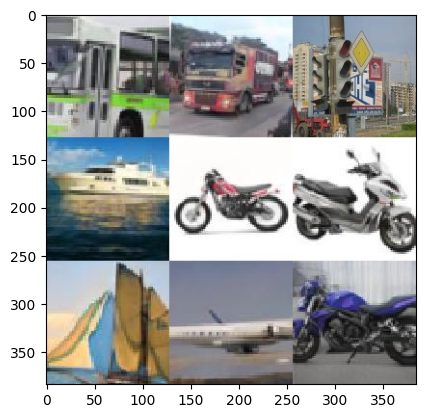

In [178]:
bgr, rgb, r = format(test)
plt.imshow(rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0
128 128


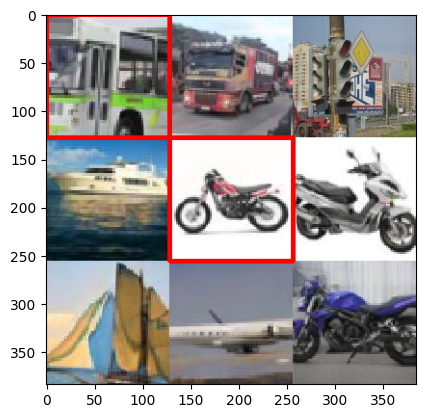

In [179]:
def putbox(img, pos):
    width = 128
    height = 128
    for x,y in pos:
        startx = x*height
        starty = y*width
        print(startx, starty)
        cv2.rectangle(img, (startx, starty), (startx + width, starty + height), (255, 0, 0), 4)
    plt.imshow(img)
putbox(rgb, [(0,0),(1,1)])